# Praktikum 4: tehisnärvivõrgud (2)

In [4]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/ai")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Numpy
import numpy as np

# Keras
from keras.layers import Dense, Input, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.models import load_model

# Pandas
import pandas as pd

# Sklearn
import sklearn.preprocessing
import sklearn.utils
from sklearn.model_selection import train_test_split

# Visualiseerimine
import matplotlib.pyplot as plt
%matplotlib inline

## Sissejuhatus

### Mudel

Kuna hakkame katsetama erinevate mudelite, andmete ja parameetritega ning tulemusi võrdlema, oleks mõistlik luua funktsioon, mis tagastab mudeli vastavalt etteantud parameetritele. 

Epohhide arvud on juhendis hoitud võimalikult väikesed, et kõik katsed oleksid praktikumi vältel läbitavad. Tegelikult ei anna nii madalate epohhide arvudega treenimine kindlasti adekvaatseid tulemusi, kuid kui treenimise käigus on näha tulemuste stabiliseerumine, siis järelikult ei aita epohhide arvu suurendamine tulemusi parandada.

#### Ülesanne

Looge funktsioon, mis saab argumentidena ette muutujad "inputshape" (sisendi pikkus, vt. eelmist praktikumi) "loss" (kao väärtuse arvutamise strateegia, näiteks "mean_squared_error") ja "opt" (optimeerimisfunktsiooni nimi, näiteks "sgd") ning tagastab eelmises praktikumis vaadatud keerulisema mudeli, mis on kompileeritud etteantud parameetritega.

In [19]:
def model(inputshape, loss, opt):
    mdl = Sequential()

    mdl.add(Dense(64, activation="tanh", input_shape=(inputshape,)))
    mdl.add(BatchNormalization())
    mdl.add(Dense(32, activation="tanh"))
    mdl.add(BatchNormalization())
    mdl.add(Dense(16, activation="selu"))
    mdl.add(BatchNormalization())
    mdl.add(Dense(7, activation="linear"))
    mdl.add(Dense(1, activation="linear"))

    mdl.compile(loss=loss, optimizer=opt)
    return mdl

### Andmed

Samuti otsime üles eelmise praktikumi teemantide andmefaili, ka seda läheb selles praktikumis vaja. 

In [50]:
failinimi = 'diamonds.csv'
teemandid = pd.read_csv(failinimi, delimiter=",")
tunnused = [i for i in teemandid]
print(tunnused)
teemandid = sklearn.utils.shuffle(teemandid)

['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']


Normaliseerime arvulised andmed.

In [51]:
scaler = sklearn.preprocessing.MinMaxScaler()
teemandid[["carat", "depth", "table", "x", "y", "z"]] = scaler.fit_transform(teemandid[["carat", "depth", "table", "x", "y", "z"]])

scaler_y = sklearn.preprocessing.MinMaxScaler()
teemandid[["price"]] = scaler_y.fit_transform(teemandid[["price"]])

**NB!** Paneme tähele, et me treenime normaliseerijat ja saame seda kasutada tulevikus ka vastupidiseks operatsiooniks, kus teisendame normaliseeritud andmed taas tagasi algsesse suurusjärku (meetodi *inverse_transform* abil). Aga sellest praktikumi lõpus.

Ka selles praktikumis ennustame teemandi hindasid, kuid tunnustena loeme sisse kõik tulbad (välja arvatud ID ja ennustatav tunnus *price*), mitte ainult numbrilised. 

In [52]:
X = teemandid.drop(columns = ['Unnamed: 0', 'price'])
y = teemandid[['price']]

### Mudeli katsetamine

#### Ülesanne

Katsetage oma funktsiooni sarnaselt eelmisele korrale. Muudame praegu X-hulka (jätame alles vaid õiged tulbad), aga arvestame, et hilisemates ülesannetes loeme andmed uuesti sisse! 

In [11]:
X = X[["carat", "depth", "table", "x", "y", "z"]]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

mdl = model(X_train.shape[1], 'mean_squared_error', 'adam')
hist = mdl.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=40, batch_size=256)

Epoch 1/40
169/169 [==============================] - 2s 4ms/step - loss: 0.0593 - val_loss: 0.0538
Epoch 2/40
169/169 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0504
Epoch 3/40
169/169 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0309
Epoch 4/40
169/169 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.0159
Epoch 5/40
169/169 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.0098
Epoch 6/40
169/169 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0065
Epoch 7/40
169/169 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 8/40
169/169 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 9/40
169/169 [==============================] - 1s 3ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 10/40
169/169 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0061

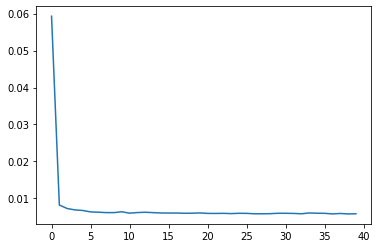

In [21]:
plt.plot(hist.history["loss"])

## Nominaalsete tunnuste teisendamine

Tehisnärvivõrgud töötavad numbriliste tunnustega, aga meie teemandeid iseloomustavad ka erinevad tekstilised väärtused: viimistlus (*cut*), värv (*color*) ja läbipaistvus (*clarity*). Mõistliku eeltöötluse tegemiseks peaksime uurima andmete kirjeldust (näiteks nende allikast https://www.kaggle.com/shivam2503/diamonds). 

Vahel võime tekstilisi andmeid käsitleda kui klasse, kuid vahel võivad need iseloomustada ka skaalat (näiteks praegusel juhul): https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621 

#### Ülesanne

Teisendage viimistluse kohta käivad andmed numbrilisteks, kasutades 1-hot vektoreid, aga hoidke ka algne veerg alles. Kontrollige, kas tulemus on õige. Seejärel võrrelge, kuidas muutub hinna ennustamise täpsus võrreldes eelmise variandiga, kui:
- kasutate ainult uusi vektoreid;
- kasutate uusi vektoreid koos seniste numbriliste tunnustega. 

Võrdlemisel kasutage muidugi samu epohhide arve.

In [27]:
teemandid

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
3076,3077,0.145530,Premium,D,SI2,0.541667,0.307692,0.161432,0.575419,0.104075,0.121069
44231,44232,0.081081,Premium,D,SI2,0.505556,0.326923,0.067362,0.504655,0.091171,0.103774
37376,37377,0.041580,Ideal,I,IF,0.538889,0.250000,0.035465,0.437616,0.080306,0.092453
27193,27194,0.376299,Ideal,G,SI1,0.450000,0.269231,0.928042,0.766294,0.139049,0.152830
6898,6899,0.110187,Ideal,D,VS2,0.491667,0.269231,0.205871,0.543762,0.099830,0.111635
...,...,...,...,...,...,...,...,...,...,...,...
21988,21989,0.207900,Premium,G,VVS2,0.505556,0.288462,0.525869,0.640596,0.116129,0.132075
8250,8251,0.216216,Fair,F,SI2,0.608333,0.326923,0.218900,0.623836,0.112564,0.135849
6891,6892,0.166320,Ideal,I,SI1,0.516667,0.307692,0.205817,0.590317,0.108998,0.123585
50230,50231,0.103950,Ideal,I,VS2,0.533333,0.230769,0.103044,0.527002,0.096604,0.111006


In [64]:
X = teemandid.drop(columns = ['Unnamed: 0', 'price'])
y = teemandid[['price']]
print(X.shape)
X.head()

(53940, 9)


,carat,cut,color,clarity,depth,table,x,y,z
53877,0.118503,Premium,F,SI1,0.472222,0.346154,0.555866,0.100679,0.112264
12088,0.224532,Premium,H,SI2,0.541667,0.365385,0.641527,0.116129,0.135220
28164,0.020790,Ideal,H,VVS1,0.533333,0.230769,0.400372,0.073345,0.084277
26354,0.024948,Premium,F,VS2,0.508333,0.326923,0.406890,0.074703,0.084591
31910,0.020790,Ideal,G,VS1,0.544444,0.269231,0.399441,0.072496,0.084277


In [66]:
# Mudeli testimine, kasutades ainult 1-hot vektoreid tunnusest "cut" 
# (loome vastava tunnuste hulga Xcut1hot)
onehot = sklearn.preprocessing.OneHotEncoder()
Xcut1hot = onehot.fit_transform(X[['cut']]).toarray()
labels = onehot.get_feature_names(['cut'])

mdl2 = model(Xcut1hot.shape[1], 'mean_squared_error', 'adam')
hist = mdl2.fit(Xcut1hot, y, epochs=40, batch_size=256)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/40
211/211 [==============================] - 2s 2ms/step - loss: 0.1031
Epoch 2/40
211/211 [==============================] - 1s 3ms/step - loss: 0.0468
Epoch 3/40
211/211 [==============================] - 1s 4ms/step - loss: 0.0464
Epoch 4/40
211/211 [==============================] - 1s 6ms/step - loss: 0.0466
Epoch 5/40
211/211 [==============================] - 1s 3ms/step - loss: 0.0468
Epoch 6/40
211/211 [==============================] - 1s 2ms/step - loss: 0.0467
Epoch 7/40
211/211 [==============================] - 0s 2ms/step - loss: 0.0465
Epoch 8/40
211/211 [==============================] - 1s 4ms/step - loss: 0.0467
Epoch 9/40
211/211 [==============================] - 1s 4ms/step - loss: 0.0466
Epoch 10/40
211/211 [==============================] - 1s 2ms/step - loss: 0.0468
Epoch 11/40
211/211 [==============================] - 0s 2ms/step - loss: 0.0467
Epoch 12/40
211/211 [==============================] - 1s 2ms/step - loss: 0.0464
Epoch 13/40
211/211 [====

In [68]:
# Mudeli testimine, kasutades endisi numbrilisi tunnuseid koos uute 1-hot vektoritega tunnusest "cut" 
# (loome vastava tunnuste hulga Xnumeral ja seejärel ühise Xall1hot)
Xnumeral = X[["carat", "depth", "table", "x", "y", "z"]]
Xall1hot = pd.concat([Xnumeral, pd.DataFrame(Xcut1hot,columns=labels).astype(int)], axis=1)

mdl3 = model(Xall1hot.shape[1], 'mean_squared_error', 'adam')
hist = mdl3.fit(Xall1hot, y, epochs=40, batch_size=256)

Epoch 1/40
211/211 [==============================] - 2s 3ms/step - loss: 0.0598
Epoch 2/40
211/211 [==============================] - 1s 3ms/step - loss: 0.0478
Epoch 3/40
211/211 [==============================] - 1s 3ms/step - loss: 0.0473
Epoch 4/40
211/211 [==============================] - 1s 3ms/step - loss: 0.0473
Epoch 5/40
211/211 [==============================] - 1s 2ms/step - loss: 0.0471
Epoch 6/40
211/211 [==============================] - 1s 2ms/step - loss: 0.0470
Epoch 7/40
211/211 [==============================] - 1s 2ms/step - loss: 0.0466
Epoch 8/40
211/211 [==============================] - 1s 2ms/step - loss: 0.0466
Epoch 9/40
211/211 [==============================] - 1s 3ms/step - loss: 0.0467
Epoch 10/40
211/211 [==============================] - 1s 2ms/step - loss: 0.0467
Epoch 11/40
211/211 [==============================] - 1s 2ms/step - loss: 0.0466
Epoch 12/40
211/211 [==============================] - 1s 2ms/step - loss: 0.0465
Epoch 13/40
211/211 [====

#### Ülesanne

Kuna viimistlus koosneb küll tekstilistest väärtustest ning võime seda käsitleda kui erinevaid klasse, on reaalselt tegemist siiski skaalaga (*Fair*, *Good*, *Very Good*, *Premium*, *Ideal*). Püüame luua uue tulba (näiteks *cut_scale*), kus tulba *cut* väärtused oleksid teisendatud normaliseeritud skaalale (vahemikus 0-1), kus 0 tähistaks varianti *Fair*, 1 varianti *Ideal*. 

In [69]:
cat = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
teemandid['cut_scale'] = teemandid['cut'].map(cat)

scaler_cut = sklearn.preprocessing.MinMaxScaler()
teemandid[['cut_scale']] = scaler_cut.fit_transform(teemandid[['cut_scale']])
teemandid.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z,cut_scale
53877,53878,0.118503,Premium,F,SI1,0.472222,0.346154,0.130778,0.555866,0.100679,0.112264,0.75
12088,12089,0.224532,Premium,H,SI2,0.541667,0.365385,0.261394,0.641527,0.116129,0.135220,0.75
28164,28165,0.020790,Ideal,H,VVS1,0.533333,0.230769,0.018327,0.400372,0.073345,0.084277,1.00
26354,26355,0.024948,Premium,F,VS2,0.508333,0.326923,0.017246,0.406890,0.074703,0.084591,0.75
31910,31911,0.020790,Ideal,G,VS1,0.544444,0.269231,0.024328,0.399441,0.072496,0.084277,1.00


In [71]:
XcutScale = teemandid['cut_scale']
#print(XcutScale)

In [72]:
XallScale = Xnumeral.join(XcutScale)

mdl4 = model(XallScale.shape[1], 'mean_squared_error', 'adam')
hist = mdl4.fit(XallScale, y, epochs=40, batch_size=256)

Epoch 1/40
211/211 [==============================] - 1s 3ms/step - loss: 0.0309
Epoch 2/40
211/211 [==============================] - 1s 3ms/step - loss: 0.0070
Epoch 3/40
211/211 [==============================] - 1s 3ms/step - loss: 0.0068
Epoch 4/40
211/211 [==============================] - 1s 3ms/step - loss: 0.0066
Epoch 5/40
211/211 [==============================] - 1s 3ms/step - loss: 0.0066
Epoch 6/40
211/211 [==============================] - 1s 3ms/step - loss: 0.0064
Epoch 7/40
211/211 [==============================] - 1s 3ms/step - loss: 0.0064
Epoch 8/40
211/211 [==============================] - 1s 3ms/step - loss: 0.0064
Epoch 9/40
211/211 [==============================] - 1s 3ms/step - loss: 0.0064
Epoch 10/40
211/211 [==============================] - 1s 2ms/step - loss: 0.0063
Epoch 11/40
211/211 [==============================] - 1s 3ms/step - loss: 0.0062
Epoch 12/40
211/211 [==============================] - 1s 3ms/step - loss: 0.0062
Epoch 13/40
211/211 [====

## Optimeerimisfunktsioonide testimine

Kasutasime seni peamiselt vaid üht optimeerimisfunktiooni, aga tegelikult on neid palju: 

https://medium.com/data-science-group-iitr/loss-functions-and-optimization-algorithms-demystified-bb92daff331c

Kerase optimeerijad: https://keras.io/optimizers/ 

#### Ülesanne

Katsetame, milline optimiseerija on praegusel juhul vaikeparameetritega parem, kas *Adam*, *SGD* või *RMSProp*. Millised on erinevused (täpsuses, stabiilsuses, kiiruses), kui kasutame endisi numbrilisi väärtusi koos viimistluse 1-hot vektoritega või endisi numbrilisi väärtusi koos viimistluse skaalaks teisendamisega?

In [76]:
mdl_adam = model(XallScale.shape[1], 'mean_squared_error', 'adam')
hist_adam = mdl_adam.fit(XallScale[5000:], y[5000:], epochs=20, batch_size=64, validation_data=(XallScale[:5000], y[:5000]))

Epoch 1/20
765/765 [==============================] - 3s 3ms/step - loss: 0.0578 - val_loss: 0.0122
Epoch 2/20
765/765 [==============================] - 3s 4ms/step - loss: 0.0096 - val_loss: 0.0114
Epoch 3/20
765/765 [==============================] - 2s 3ms/step - loss: 0.0082 - val_loss: 0.0137
Epoch 4/20
765/765 [==============================] - 3s 4ms/step - loss: 0.0079 - val_loss: 0.0087
Epoch 5/20
765/765 [==============================] - 2s 3ms/step - loss: 0.0075 - val_loss: 0.0095
Epoch 6/20
765/765 [==============================] - 4s 5ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 7/20
765/765 [==============================] - 5s 6ms/step - loss: 0.0073 - val_loss: 0.0088
Epoch 8/20
765/765 [==============================] - 4s 5ms/step - loss: 0.0072 - val_loss: 0.0114
Epoch 9/20
765/765 [==============================] - 4s 6ms/step - loss: 0.0072 - val_loss: 0.0213
Epoch 10/20
765/765 [==============================] - 2s 3ms/step - loss: 0.0071 - val_loss: 0.0077

In [77]:
mdl_sgd = model(XallScale.shape[1], 'mean_squared_error', 'sgd')
hist_sgd = mdl_sgd.fit(XallScale[5000:], y[5000:], epochs=20, batch_size=64, validation_data=(XallScale[:5000], y[:5000]))

Epoch 1/20
765/765 [==============================] - 3s 2ms/step - loss: 0.0152 - val_loss: 0.0071
Epoch 2/20
765/765 [==============================] - 2s 2ms/step - loss: 0.0081 - val_loss: 0.0070
Epoch 3/20
765/765 [==============================] - 2s 2ms/step - loss: 0.0075 - val_loss: 0.0064
Epoch 4/20
765/765 [==============================] - 2s 2ms/step - loss: 0.0074 - val_loss: 0.0061
Epoch 5/20
765/765 [==============================] - 2s 3ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 6/20
765/765 [==============================] - 2s 3ms/step - loss: 0.0072 - val_loss: 0.0067
Epoch 7/20
765/765 [==============================] - 2s 2ms/step - loss: 0.0069 - val_loss: 0.0061
Epoch 8/20
765/765 [==============================] - 2s 2ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 9/20
765/765 [==============================] - 2s 2ms/step - loss: 0.0069 - val_loss: 0.0060
Epoch 10/20
765/765 [==============================] - 2s 2ms/step - loss: 0.0069 - val_loss: 0.0062

In [78]:
mdl_rmsprop = model(XallScale.shape[1], 'mean_squared_error', 'rmsprop')
hist_rmsprop = mdl_rmsprop.fit(XallScale[5000:], y[5000:], epochs=20, batch_size=64, validation_data=(XallScale[:5000], y[:5000]))

Epoch 1/20
765/765 [==============================] - 3s 3ms/step - loss: 0.0158 - val_loss: 0.0254
Epoch 2/20
765/765 [==============================] - 2s 2ms/step - loss: 0.0088 - val_loss: 0.0066
Epoch 3/20
765/765 [==============================] - 2s 2ms/step - loss: 0.0084 - val_loss: 0.0072
Epoch 4/20
765/765 [==============================] - 2s 2ms/step - loss: 0.0081 - val_loss: 0.0107
Epoch 5/20
765/765 [==============================] - 2s 2ms/step - loss: 0.0078 - val_loss: 0.0115
Epoch 6/20
765/765 [==============================] - 2s 2ms/step - loss: 0.0077 - val_loss: 0.0082
Epoch 7/20
765/765 [==============================] - 2s 2ms/step - loss: 0.0076 - val_loss: 0.0110
Epoch 8/20
765/765 [==============================] - 2s 2ms/step - loss: 0.0074 - val_loss: 0.0082
Epoch 9/20
765/765 [==============================] - 2s 2ms/step - loss: 0.0072 - val_loss: 0.0088
Epoch 10/20
765/765 [==============================] - 2s 2ms/step - loss: 0.0073 - val_loss: 0.0059

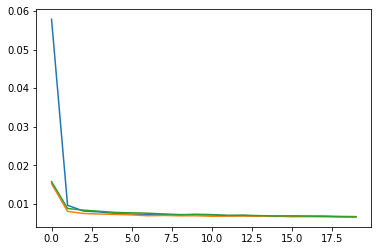

In [79]:
plt.plot(hist_adam.history["loss"])
plt.plot(hist_sgd.history["loss"])
plt.plot(hist_rmsprop.history["loss"])

## Mudeli salvestamine ja avamine

Nagu näeme, on mudeli treenimine pikaajaline protsess sõltuvalt andmehulga suurusest, mudeli keerukusest, epohhide arvust jne. Selle asemel, et iga kord mudelit uuesti treenida, võime me mudelid salvestada failina. 

In [80]:
# Teeme uuesti kõik läbi
teemandid = pd.read_csv(failinimi, delimiter=",")
teemandid = sklearn.utils.shuffle(teemandid)

# Jätame meelde ka õiged vastused (normaliseerimata kujul), neid läheb meil hiljem vaja
#pricesReal = teemandid.price.values.reshape(-1,1)
y_real = teemandid[['price']]
#print(y_real)

scaler = sklearn.preprocessing.MinMaxScaler()
teemandid[["carat", "depth", "table", "x", "y", "z"]] = scaler.fit_transform(teemandid[["carat", "depth", "table", "x", "y", "z"]])

scaler_y = sklearn.preprocessing.MinMaxScaler()
teemandid[["price"]] = scaler_y.fit_transform(teemandid[["price"]])

X = teemandid.drop(columns = ['Unnamed: 0', 'price'])
X = X[["carat", "depth", "table", "x", "y", "z"]]
y = teemandid[['price']]

input_shape = X.shape[1]
mdl = model(input_shape, "mean_squared_error", "sgd")
hist = mdl.fit(X, y, epochs=10, batch_size=256, verbose=True)

Epoch 1/10
211/211 [==============================] - 2s 2ms/step - loss: 0.0344
Epoch 2/10
211/211 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 3/10
211/211 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 4/10
211/211 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 5/10
211/211 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 6/10
211/211 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 7/10
211/211 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 8/10
211/211 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 9/10
211/211 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 10/10
211/211 [==============================] - 0s 2ms/step - loss: 0.0072


In [81]:
# Salvestame mudeli (vaadake tekkinud faili Colabi kaustas vms) ja kustutame selle mälust
mdl.save('mudel.h5')  
del mdl 

In [82]:
# Laeme mudeli uuesti (paremaks demonstreerimiseks uue nimega)
mdlFromDisk = load_model('mudel.h5')

# Ennustame hindasid X-hulga esimesel kahekümnel real
y_pred = mdlFromDisk.predict([X[:20]])
#print(y_pred)

## Normaliseerimise pöördfunktsioon

Kuna me normaliseerisime kõiki numbrilisi väärtusi (sh. hinda), siis saime ka ennustused normaliseeritud kujul. Selleks, et vaadata tulemusi õiges mõõtkavas ehk reaalsete hindadena, peame me ennustused konverteerima tagasi, kasutades juba treenitud skaleerija funktsiooni *inverse_transform()*.

In [83]:
print("Ennustatud hinnad (normaliseeritult) - Ennustatud hinnad (reaalsel kujul) - Õiged hinnad")

y_real_list = y_real[["price"]]

for i in range(20):
    print(y_pred[i][0], '-', round(scaler_y.inverse_transform([y_pred[i]])[0][0]), '-', y_real[["price"]].iloc[i][0])

Ennustatud hinnad (normaliseeritult) - Ennustatud hinnad (reaalsel kujul) - Õiged hinnad
0.30741337 - 6012 - 7455
0.021899257 - 731 - 1110
0.016324723 - 628 - 731
0.24809599 - 4915 - 4276
0.3502234 - 6804 - 4649
0.44865188 - 8625 - 5958
0.03595397 - 991 - 706
0.54401284 - 10389 - 11795
0.29143354 - 5717 - 6564
0.1163508 - 2478 - 2333
0.012699552 - 561 - 462
0.021338068 - 721 - 1079
0.28515172 - 5600 - 7332
0.38356557 - 7421 - 4269
0.049728476 - 1246 - 1229
0.59540623 - 11339 - 8496
0.29726064 - 5824 - 4340
0.25074533 - 4964 - 4200
0.12872428 - 2707 - 2242
0.051438905 - 1277 - 485


## Klassifitseerimine närvivõrkude abil
### Binaarne klassifitseerimine 

Enamiku seni nähtud näidete puhul tegelesime me regressiooniga ehk arvulise väärtuse leidmisega, kuid närvivõrkude abil saab ka klassifitseerida. Sisuliselt tegime seda juba eelmise praktikumi esimese näite puhul (XOR tehe), kus soovisime teada, kas väljund on 1 või 0 või (teisiti sõnastatuna) kas väljund on tõene või väär. Sel puhul oli tegemist klassifitseerimisega, täpsemalt binaarse klassifitseerimisega (kas objekt kuulub mingisse klassi või ei kuulu).

Kasutame jätkuvalt samu andmeid ehk teemantide andmebaasi.

In [84]:
failinimi = 'diamonds.csv'
teemandid = pd.read_csv(failinimi, delimiter=",")
tunnused = [i for i in teemandid]
print(tunnused)
teemandid = sklearn.utils.shuffle(teemandid)

['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']


Teemantide näite puhul meil otseselt binaarset tulpa pole ehk pole tulpa, kus on täpselt 2 võimalikku väärtust. Samas võime me sellise tulba seniste andmete põhjal luua, võttes näiteks viimistlust (*cut*) iseloomustava klassi ning grupeerides väärtused näiteks nn. hea viimistlusega teemantideks ja ülejäänuteks. 

Võiksime mõelda, et hea viimistlusega teemandid võiksid olla näiteks need, mille tunnuse *cut* väärtus on kas *Ideal* või *Premium*. Võimalik, et see ongi etteantud tingimuste puhul vajalik, kuid kuna soovime praegu klassifitseerimist katsetada, siis oleks hea, kui klassid oleksid tasakaalus. Vaatame, kuidas väärtused tulbas "cut" jagunevad.


In [85]:
teemandid.groupby("cut").size()

cut
Fair          1610
Good          4906
Ideal        21551
Premium      13791
Very Good    12082
dtype: int64

Nagu näeme, on väärtus "Ideal" suures ülekaalus ning kui paneksime kokku klassid "Ideal" ja "Premium", saaksime tulemuseks suure ülekaaluga uue klassi. Seega kasutame ainult esimest.
Selleks teeme uue tunnuse (näiteks "cut_binary") ja täidame selle vastavalt tulbale "cut" kas arvuga 1 (kui kirje "cut" väärtus on "Ideal") või arvuga 0 (kui see nii pole). 

In [86]:
teemandid["cut_binary"] = 0
teemandid.loc[teemandid['cut'] == "Ideal", 'cut_binary'] = 1
# Kui tahaksime siiski proovida klasse "Ideal" ja "Premium", siis nii:
#teemandid.loc[teemandid['cut'].isin(["Ideal", "Premium"]), 'cut_binary'] = 1

In [87]:
teemandid.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z,cut_binary
8775,8776,1.00,Good,H,SI1,57.9,54.0,4469,6.68,6.62,3.85,0
30837,30838,0.33,Premium,H,VS1,59.5,59.0,743,4.53,4.48,2.68,0
47635,47636,0.51,Ideal,D,VS2,61.8,55.0,1882,5.18,5.15,3.19,1
50050,50051,0.70,Ideal,F,SI1,62.6,56.0,2200,5.69,5.66,3.55,1
12827,12828,1.05,Ideal,F,SI2,61.9,56.0,5347,6.48,6.50,4.02,1


Vaatame, milline on tasakaal klasside vahel.

In [88]:
teemandid.groupby("cut_binary").size()

cut_binary
0    32389
1    21551
dtype: int64

Jagame andmed treening- ja testhulgaks nagu varemgi. 

In [89]:
from sklearn.model_selection import train_test_split

X = teemandid[["carat", "depth", "table", "x", "y", "z","price"]]
y = teemandid[["cut_binary"]]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
print(X_train.shape)
print(y_train.shape)

(43152, 7)
(43152, 1)


Kuna "unustasime" normaliseerimise, teeme seda nüüd. Tegelikult teeme seda alles nüüd sellepärast, et tuletada meelde, kuidas käitume päriselus: õpetame skaleerija välja ainult treeninghulga peal, kuna testhulga elemendid ("homne ilm") on mudeli õpetamise ajal meil veel teadmata. Küll aga teisendame kindlasti ka testhulga elemendid, kasutades treeninghulgal õpetatud skaleerijat. 

In [90]:
scaler = sklearn.preprocessing.MinMaxScaler()
X_train[["carat", "depth", "table", "x", "y", "z","price"]] = scaler.fit_transform(X_train[["carat", "depth", "table", "x", "y", "z","price"]])
X_test[["carat", "depth", "table", "x", "y", "z","price"]] = scaler.transform(X_test[["carat", "depth", "table", "x", "y", "z","price"]])

Koostame samasuguse mudeli nagu varemgi, kuid kaofunktsiooniks (*loss*) on keskmise ruutvea asemel *binary_crossentropy*, sest meid huvitab vea puhul just täpsus kahte klassi jaotamise puhul. Samal põhjusel laseme arvutata välja ka klassidesse jagamise täpsuse (*accuracy*).

In [91]:
mdl = Sequential()

mdl.add(Dense(64, activation="tanh", input_shape=(X_train.shape[1],)))
mdl.add(BatchNormalization())
mdl.add(Dense(32, activation="tanh"))
mdl.add(BatchNormalization())
mdl.add(Dense(16, activation="selu"))
mdl.add(BatchNormalization())
mdl.add(Dense(8, activation="linear"))
mdl.add(Dense(1, activation="sigmoid"))

mdl.compile(loss='binary_crossentropy', optimizer="adam", metrics = ["accuracy"])

In [92]:
hist = mdl.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=10, batch_size=256)

Epoch 1/10
169/169 [==============================] - 2s 4ms/step - loss: 0.4068 - accuracy: 0.8286 - val_loss: 0.8914 - val_accuracy: 0.3981
Epoch 2/10
169/169 [==============================] - 1s 3ms/step - loss: 0.3447 - accuracy: 0.8674 - val_loss: 0.5672 - val_accuracy: 0.6978
Epoch 3/10
169/169 [==============================] - 1s 3ms/step - loss: 0.3344 - accuracy: 0.8708 - val_loss: 0.4085 - val_accuracy: 0.8237
Epoch 4/10
169/169 [==============================] - 1s 3ms/step - loss: 0.3303 - accuracy: 0.8728 - val_loss: 0.4365 - val_accuracy: 0.8017
Epoch 5/10
169/169 [==============================] - 1s 3ms/step - loss: 0.3269 - accuracy: 0.8732 - val_loss: 0.3368 - val_accuracy: 0.8586
Epoch 6/10
169/169 [==============================] - 1s 3ms/step - loss: 0.3230 - accuracy: 0.8753 - val_loss: 0.3335 - val_accuracy: 0.8619
Epoch 7/10
169/169 [==============================] - 1s 3ms/step - loss: 0.3203 - accuracy: 0.8785 - val_loss: 0.3191 - val_accuracy: 0.8745
Epoch 

Lihtsalt näitlikustamise mõttes võtame mõned testhulga kirjed, laseme nende põhjal ennustada ja vaatame, kas ennustused vastavad õigetele vastustele. Ennustamisel ümardame tulemuse täisarvuni, kuid trükime praegu välja ka ennustuse algsel kujul.

In [93]:
y_pred = mdl.predict(X_test[:10])
#print(y_pred)
for i in range(len(y_pred)):
  #print(X_test.iloc[i])
  print("Õige vastus:", y_test.iloc[i]["cut_binary"], "- ennustatud vastus:", round(y_pred[i][0]), "täpsemalt:", y_pred[i][0])

Õige vastus: 0 - ennustatud vastus: 1 täpsemalt: 0.8804866
Õige vastus: 0 - ennustatud vastus: 0 täpsemalt: 0.014630377
Õige vastus: 0 - ennustatud vastus: 0 täpsemalt: 0.43556476
Õige vastus: 0 - ennustatud vastus: 0 täpsemalt: 0.24707028
Õige vastus: 0 - ennustatud vastus: 0 täpsemalt: 0.012918234
Õige vastus: 1 - ennustatud vastus: 1 täpsemalt: 0.91739196
Õige vastus: 0 - ennustatud vastus: 0 täpsemalt: 0.008388877
Õige vastus: 0 - ennustatud vastus: 0 täpsemalt: 0.23173615
Õige vastus: 0 - ennustatud vastus: 0 täpsemalt: 0.049192697
Õige vastus: 0 - ennustatud vastus: 0 täpsemalt: 0.00027889013


### Mitu klassi
Ka rohkema kui kaks klassi puhul on töö väga sarnane, erinevus on mudeli väljundkihi kujus. Kasutame ka siin teemantide andmebaasi ja tunnust "cut" ning (nagu varemgi) peame ka nüüd tegema eeltöötlust, kuna taas vajame ainult arvulisel kujul andmeid. Seega kasutame 1-hot vektoriseerimist ja nii saame tulba "cut" iga erineva väärtuse kohta ühe uue tulba. Saadud viis uut tulpa ongi meie väljundiks: mudel ennustab, kui suure tõenäosusega kuulub etteantud teemant igasse antud klassi.

In [94]:
failinimi = 'diamonds.csv'
teemandid = pd.read_csv(failinimi, delimiter=",")
tunnused = [i for i in teemandid]
print(tunnused)
teemandid = sklearn.utils.shuffle(teemandid)

['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']


In [95]:
onehot = pd.get_dummies(teemandid['cut'])
lisatudCutTunnused = [i for i in onehot]
teemandid = teemandid.join(onehot)
teemandid.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z,Fair,Good,Ideal,Premium,Very Good
6821,6822,0.90,Good,F,SI1,62.5,59.0,4119,6.10,6.13,3.82,0,1,0,0,0
21800,21801,1.21,Ideal,G,VS2,60.1,57.0,9873,6.94,6.98,4.18,0,0,1,0,0
27977,27978,0.30,Very Good,E,VS2,62.4,57.0,658,4.24,4.29,2.66,0,0,0,0,1
8355,8356,1.02,Ideal,F,SI2,62.4,57.0,4398,6.43,6.40,4.00,0,0,1,0,0
36460,36461,0.31,Ideal,D,VS2,62.9,55.0,942,4.34,4.31,2.72,0,0,1,0,0


In [96]:
from sklearn.model_selection import train_test_split

X = teemandid[["carat", "depth", "table", "x", "y", "z","price"]]
y = teemandid[lisatudCutTunnused]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
print(X_train.shape)
print(y_train.shape)
print(y_test)

(43152, 7)
(43152, 5)
       Fair  Good  Ideal  Premium  Very Good
18844     0     0      0        0          1
26737     0     0      0        1          0
25913     0     0      0        1          0
42022     0     0      0        0          1
31725     0     0      0        0          1
...     ...   ...    ...      ...        ...
33968     0     0      1        0          0
13701     0     0      0        1          0
31203     0     0      0        1          0
27886     0     0      1        0          0
13531     0     0      0        1          0

[10788 rows x 5 columns]


In [97]:
scaler = sklearn.preprocessing.MinMaxScaler()
X_train[["carat", "depth", "table", "x", "y", "z", "price"]] = scaler.fit_transform(X_train[["carat", "depth", "table", "x", "y", "z", "price"]])
X_test[["carat", "depth", "table", "x", "y", "z", "price"]] = scaler.transform(X_test[["carat", "depth", "table", "x", "y", "z", "price"]])

In [98]:
X_train.describe()

,carat,depth,table,x,y,z,price
count,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,0.139514,0.520892,0.278073,0.560720,0.180458,0.111389,0.195822
std,0.110367,0.039769,0.042992,0.109720,0.035250,0.022257,0.216138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.046512,0.500000,0.250000,0.461388,0.148428,0.091509,0.034060
50%,0.116279,0.522222,0.269231,0.557185,0.179560,0.111006,0.113099
75%,0.195349,0.541667,0.307692,0.640274,0.205660,0.127044,0.270963
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [99]:
X_test.describe()

,carat,depth,table,x,y,z,price
count,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000,10788.000000
mean,0.137222,0.520514,0.277823,0.558270,0.179824,0.110850,0.191680
std,0.109690,0.039900,0.042890,0.109375,0.038463,0.021924,0.213819
min,0.000000,0.000000,0.019231,0.000000,0.000000,0.000000,0.000054
25%,0.046512,0.500000,0.250000,0.459433,0.148113,0.091195,0.033141
50%,0.116279,0.525000,0.269231,0.555230,0.178931,0.110377,0.109802
75%,0.195349,0.541667,0.307692,0.637341,0.205031,0.126730,0.268111
max,1.118605,0.786111,0.692308,1.049853,1.852201,0.253459,0.998054


Loome mudeli, mis on väga sarnane eelmisele, kuid kuna meil on väljundis viis väärtust, peab ka mudeli viimase kihi suurus olema viis. Aktiveerimisfunktsioonina kasutame selles kihis *softmaxi*, mis teisendab väljundkihi viis väärtust nii, et nende summa oleks alati üks.

Kaofunktsioonina kasutame *categorical_crossentropy*, kuna erivalt eelmisest on meil tegemist rohkem kui kahe klassiga.

In [100]:
mdl = Sequential()

mdl.add(Dense(64, activation="tanh", input_shape=(X_train.shape[1],)))
mdl.add(BatchNormalization())
mdl.add(Dense(32, activation="tanh"))
mdl.add(BatchNormalization())
mdl.add(Dense(16, activation="selu"))
mdl.add(BatchNormalization())
mdl.add(Dense(8, activation="linear"))
mdl.add(Dense(5, activation="softmax"))

mdl.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

In [101]:
hist = mdl.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=10, batch_size=256)

Epoch 1/10
169/169 [==============================] - 2s 4ms/step - loss: 1.1533 - accuracy: 0.5696 - val_loss: 1.3208 - val_accuracy: 0.4285
Epoch 2/10
169/169 [==============================] - 1s 3ms/step - loss: 0.8478 - accuracy: 0.6852 - val_loss: 1.4896 - val_accuracy: 0.4220
Epoch 3/10
169/169 [==============================] - 1s 3ms/step - loss: 0.7273 - accuracy: 0.7222 - val_loss: 1.3527 - val_accuracy: 0.5225
Epoch 4/10
169/169 [==============================] - 1s 3ms/step - loss: 0.6911 - accuracy: 0.7343 - val_loss: 1.1288 - val_accuracy: 0.5512
Epoch 5/10
169/169 [==============================] - 1s 3ms/step - loss: 0.6737 - accuracy: 0.7405 - val_loss: 3.3142 - val_accuracy: 0.2685
Epoch 6/10
169/169 [==============================] - 1s 3ms/step - loss: 0.6625 - accuracy: 0.7442 - val_loss: 0.9592 - val_accuracy: 0.6460
Epoch 7/10
169/169 [==============================] - 1s 3ms/step - loss: 0.6511 - accuracy: 0.7472 - val_loss: 1.0108 - val_accuracy: 0.6248
Epoch 

Teeme ka nüüd testhulga väärtuste ennustamise ja väljatrüki tulemustest. Klasse on 5 ning ennustuseks loeme seda, mille tõenäosust ennustati kõige suuremaks (*argmax*).

In [102]:
y_pred = mdl.predict(X_test[:20])
#print(y_pred)

In [103]:
print(y_test)

       Fair  Good  Ideal  Premium  Very Good
18844     0     0      0        0          1
26737     0     0      0        1          0
25913     0     0      0        1          0
42022     0     0      0        0          1
31725     0     0      0        0          1
...     ...   ...    ...      ...        ...
33968     0     0      1        0          0
13701     0     0      0        1          0
31203     0     0      0        1          0
27886     0     0      1        0          0
13531     0     0      0        1          0

[10788 rows x 5 columns]


In [104]:
for i in range(len(y_pred)):
  print("Õige vastus:")
  print(y_test.iloc[i])
  print("Ennustatud vastus:", np.argmax(y_pred[i]), "ehk", lisatudCutTunnused[np.argmax(y_pred[i])])
  print()

Õige vastus:
Fair         0
Good         0
Ideal        0
Premium      0
Very Good    1
Name: 18844, dtype: uint8
Ennustatud vastus: 3 ehk Premium

Õige vastus:
Fair         0
Good         0
Ideal        0
Premium      1
Very Good    0
Name: 26737, dtype: uint8
Ennustatud vastus: 4 ehk Very Good

Õige vastus:
Fair         0
Good         0
Ideal        0
Premium      1
Very Good    0
Name: 25913, dtype: uint8
Ennustatud vastus: 3 ehk Premium

Õige vastus:
Fair         0
Good         0
Ideal        0
Premium      0
Very Good    1
Name: 42022, dtype: uint8
Ennustatud vastus: 1 ehk Good

Õige vastus:
Fair         0
Good         0
Ideal        0
Premium      0
Very Good    1
Name: 31725, dtype: uint8
Ennustatud vastus: 3 ehk Premium

Õige vastus:
Fair         1
Good         0
Ideal        0
Premium      0
Very Good    0
Name: 5005, dtype: uint8
Ennustatud vastus: 0 ehk Fair

Õige vastus:
Fair         0
Good         0
Ideal        0
Premium      0
Very Good    1
Name: 52943, dtype: uint8
Enn

In [105]:
print('coolcoolcool')

coolcoolcool
